In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

In [24]:
from tensorflow.keras.models import Model

def visualize_layer_outputs(model, image, n):
    """
    Pass an image through the first `n` layers of the model and plot output channels.

    Parameters:
    - model: Keras Sequential model
    - image: single input image (shape must match model input)
    - n: number of layers to include
    """
    # Ensure image has batch dimension
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    
    # Create a model up to the nth layer
    truncated_model = Model(inputs=model.inputs, outputs=model.layers[n].output)

    # Get activations
    activations = truncated_model.predict(image)
    
    # Squeeze batch dimension if needed
    if activations.ndim == 4:
        activations = np.squeeze(activations, axis=0)  # shape: (H, W, C)

    n_channels = activations.shape[-1]

    # Set up subplot grid
    n_cols = 4
    n_rows = int(np.ceil((n_channels + 1) / n_cols))  # +1 for original image
    size = 4
    
    plt.figure(figsize=(size * n_cols, size * n_rows))

    # Plot original image
    plt.subplot(n_rows, n_cols, 1)
    if image.shape[-1] == 1:
        plt.imshow(image[0, ..., 0], cmap='gray')
    else:
        plt.imshow(image[0])
    plt.title("Original")

    # Plot each channel
    for i in range(n_channels):
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(activations[..., i], cmap='gray', interpolation=None)
        plt.title(f"Channel {i}")

    plt.tight_layout()
    plt.show()

# Keras CNN on un-augmented CIFAR10 data

In [25]:
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (50000, 32, 32, 3)
X_test.shape:  (10000, 32, 32, 3)


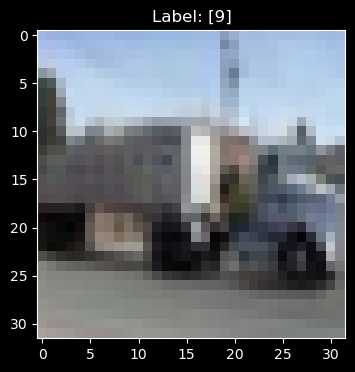

In [32]:
# Display a random image
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx])
plt.title(f"Label: {y_train[idx]}")
plt.show()

## Create/train/analyze model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

dropout_rate = 0.25

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    GlobalAveragePooling2D(),
    #Dropout(dropout_rate),
    
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(16, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Display model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │              

 Total params: 27,786 (108.54 KB)

 Trainable params: 27,546 (107.60 KB)

 Non-trainable params: 240 (960.00 B)

In [49]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay

# define training parameters
epochs          = 10
batch_size      = 1000

# Define the learning rate schedule
initial_learning_rate = 0.01

optimizer = Adam(
    learning_rate=initial_learning_rate,
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [51]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5809 - loss: 1.1764 - val_accuracy: 0.6251 - val_loss: 1.0474
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5776 - loss: 1.1788 - val_accuracy: 0.6239 - val_loss: 1.0424
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5895 - loss: 1.1536 - val_accuracy: 0.6206 - val_loss: 1.0848
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5896 - loss: 1.1569 - val_accuracy: 0.5566 - val_loss: 1.1967
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5935 - loss: 1.1430 - val_accuracy: 0.6292 - val_loss: 1.0421
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6026 - loss: 1.1236 - val_accuracy: 0.6376 - val_loss: 1.0034
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6067 - loss: 1.1150 - val_accuracy: 0.5560 - val_loss: 1.2243
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6095 - loss: 1.1040 - val_accuracy: 0.6494 - v

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


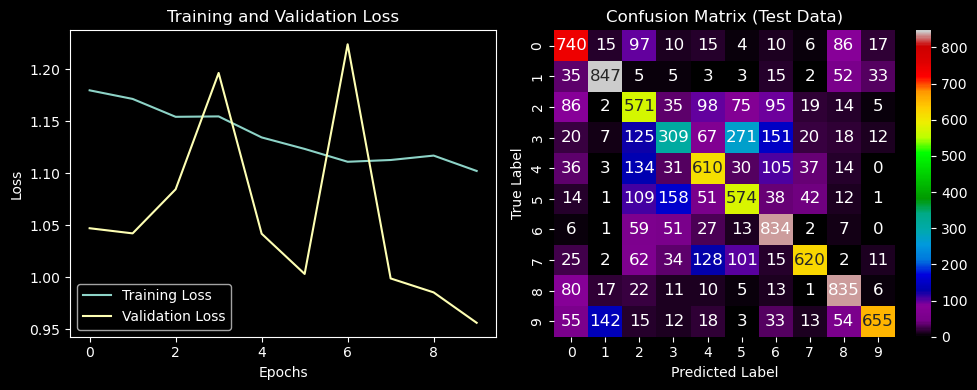

              precision    recall  f1-score   support

           0       0.67      0.74      0.71      1000
           1       0.82      0.85      0.83      1000
           2       0.48      0.57      0.52      1000
           3       0.47      0.31      0.37      1000
           4       0.59      0.61      0.60      1000
           5       0.53      0.57      0.55      1000
           6       0.64      0.83      0.72      1000
           7       0.81      0.62      0.70      1000
           8       0.76      0.83      0.80      1000
           9       0.89      0.66      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



In [52]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Visualize channels after processing

In [57]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or any image shaped like your input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


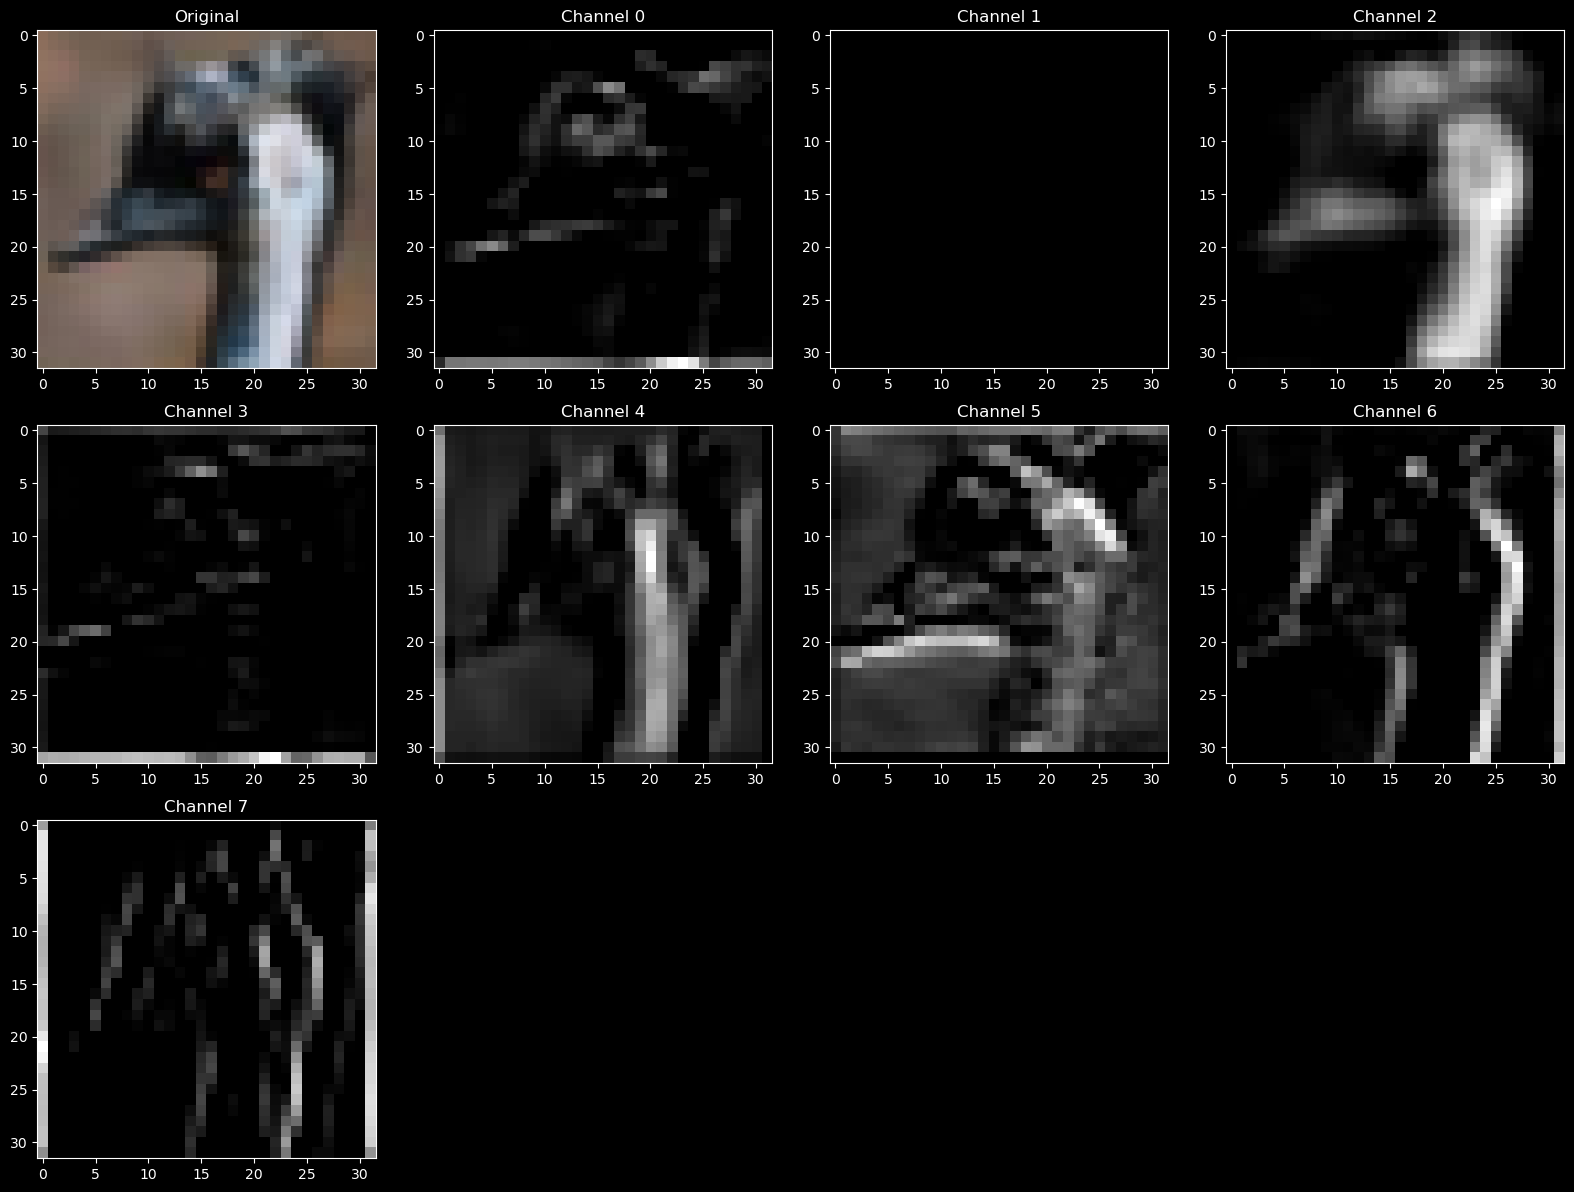

In [58]:
# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=0)